In [190]:
import pandas as pd 
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read in the data
INPUT_DIR = '../Data'
cal = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
stv = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')
ss = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sellp = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')

# Only do FOODS_3_090_CA_3_validation!

In [127]:
stv[(stv.item_id=='FOODS_3_090') & (stv.id=='FOODS_3_090_CA_3_validation')]

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
8412,FOODS_3_090_CA_3_validation,FOODS_3_090,FOODS_3,FOODS,CA_3,CA,108,132,102,120,...,129,160,204,86,100,88,77,141,139,130


In [128]:
sell_df.head(1)

,store_id,wm_yr_wk,sell_price
1862424,CA_3,11101,1.25


In [129]:
#Transform
data=stv[stv.id=='FOODS_3_090_CA_3_validation'] 
data=data.iloc[:,6:].T
data=data.reset_index()
data=data.merge(cal, left_on='index', right_on='d')
data=data.drop(['d','snap_CA', 'snap_WI','date'],axis=1)
data=data.merge(df_temp, on='wm_yr_wk' )

#Get price
prices=sellp[(sellp.item_id=='FOODS_3_090') &  sellp.store_id.isin(['CA_3'])][['store_id','wm_yr_wk','sell_price']]
prices=prices[prices.wm_yr_wk.isin(data.wm_yr_wk.unique())]
data=data.merge(prices, on='wm_yr_wk' )

#Categorical data
data=pd.concat([data,pd.get_dummies(data[['weekday','event_name_1',
                                          'event_name_2','event_type_1','event_type_2']])],axis=1)
data=data.drop(['weekday','event_name_1','event_name_2','event_type_1','event_type_2','index','store_id'],axis=1)

In [130]:
data.head(1)

,8412,wm_yr_wk,wday,month,year,snap_TX,price,sell_price,weekday_Friday,weekday_Monday,...,event_name_2_Cinco De Mayo,event_name_2_Easter,event_name_2_Father's day,event_name_2_OrthodoxEaster,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious
0,108,11101,1,1,2011,0,1.25,1.25,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
data['lag_t28']=data[8412].transform(lambda x: x.shift(28))
data['lag_t29'] = data[8412].transform(lambda x: x.shift(29))
data['lag_t30'] = data[8412].transform(lambda x: x.shift(30))
data['rolling_mean_t30'] = data[8412].transform(lambda x: x.shift(28).rolling(30).mean())
data['rolling_mean_t90'] = data[8412].transform(lambda x: x.shift(28).rolling(90).mean())
data['rolling_mean_t180'] = data[8412].transform(lambda x: x.shift(28).rolling(180).mean())
data['price_lag_1'] = data['price'].transform(lambda x: x.shift(1))

# nan till row 205

In [132]:
data.head()

,8412,wm_yr_wk,wday,month,year,snap_TX,price,sell_price,weekday_Friday,weekday_Monday,...,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious,lag_t28,lag_t29,lag_t30,rolling_mean_t30,rolling_mean_t90,rolling_mean_t180,price_lag_1
0,108,11101,1,1,2011,0,1.25,1.25,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,132,11101,2,1,2011,0,1.25,1.25,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.25
2,102,11101,3,1,2011,0,1.25,1.25,0,1,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.25
3,120,11101,4,2,2011,1,1.25,1.25,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.25
4,106,11101,5,2,2011,0,1.25,1.25,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.25


In [135]:
data.shape

(1913, 62)

In [136]:
1913-28

1885

# Modeling

In [206]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn import preprocessing, metrics

from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA

In [137]:
x_train=data.iloc[:1885,1:]
y_train=data.iloc[:1885,:1]
x_test=data.iloc[1885:,1:]
y_test=data.iloc[1885:,:1]

In [251]:
# Simple smoothing
ss = SimpleExpSmoothing(y_train).fit(smoothing_level=0.2,optimized=False)
prediction_ss = ss.forecast(28)
score_ss=np.sqrt(metrics.mean_squared_error(prediction_ss, y_test))

In [252]:
from pandas.plotting import autocorrelation_plot

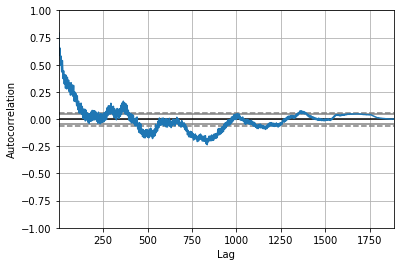

In [253]:
autocorrelation_plot(y_train)

In [257]:
#ARIMA
arm = ARIMA(y_train.values,(2, 1, 7)).fit()
arm_prediction=arm.forecast(28)
score_arm=np.sqrt(metrics.mean_squared_error(arm_prediction[1], y_test))

In [258]:
score_arm

39.572420308141865

In [ ]:
arm.plot_predict(dynamic=False, start=1800)

In [ ]:
#Random Forest
rf=RandomForestRegressor()
rf.fit(x_train.fillna(0).values,y_train)
prediction_rf=rf.predict(x_test)
score_rf=np.sqrt(metrics.mean_squared_error(prediction_rf, y_test))

In [ ]:
#XG Boost
xg_reg = xgb.XGBRegressor()
xg_reg.fit(x_train.fillna(0).values,y_train)
prediction_xg_reg=xg_reg.predict(x_test.fillna(0).values)
score_xg_reg=np.sqrt(metrics.mean_squared_error(prediction_xg_reg, y_test))

In [196]:
score_xg_reg

25.56495770612705

In [197]:
score_rf

38.49102400003706

# Plot

In [159]:
import matplotlib.pyplot as plt

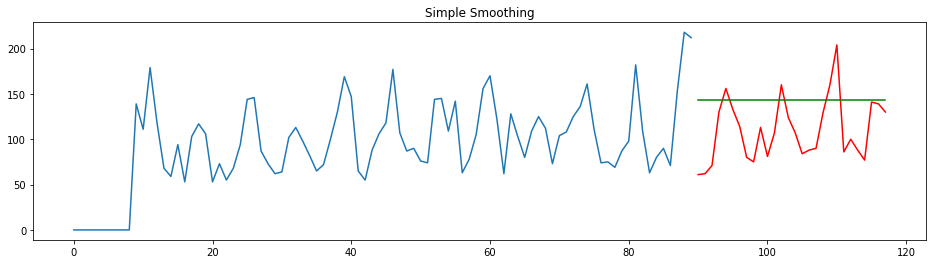

In [269]:
# Simple smoothing
starting=90

plt.figure(figsize=(16,4))
plt.plot(np.arange(starting),y_train[-starting:] )
plt.plot(range(starting,starting+len(y_test)),y_test,color='red')
plt.plot(range(starting,starting+len(y_test)),fcast1,color='green')
plt.title("Simple Smoothing")

plt.show()

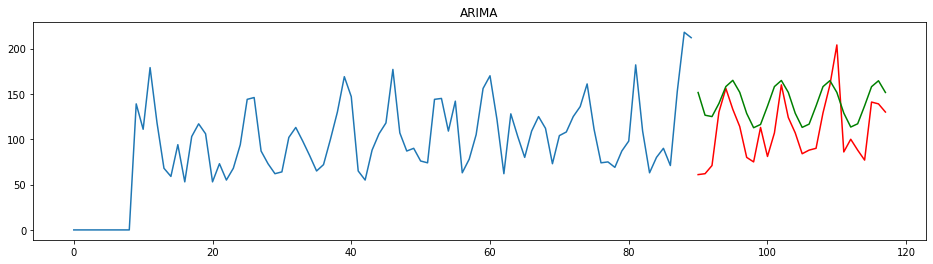

In [270]:
#ARIMA
starting=90

plt.figure(figsize=(16,4))
plt.plot(np.arange(starting),y_train[-starting:] )
plt.plot(range(starting,starting+len(y_test)),y_test,color='red')
plt.plot(range(starting,starting+len(y_test)),arm_prediction[0],color='green')
plt.title("ARIMA")

plt.show()

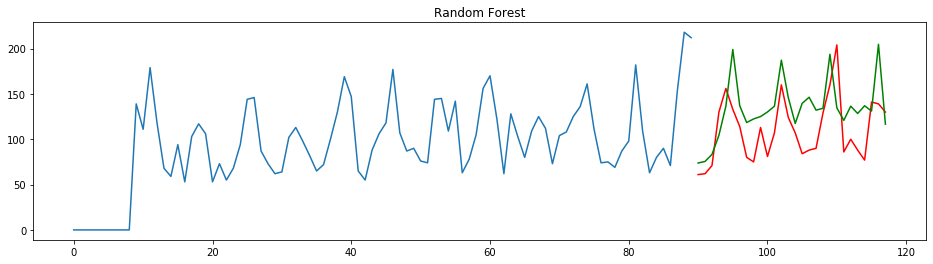

In [271]:
#Random Forest
starting=90

plt.figure(figsize=(16,4))
plt.plot(np.arange(starting),y_train[-starting:] )
plt.plot(range(starting,starting+len(y_test)),y_test,color='red')
plt.plot(range(starting,starting+len(y_test)),prediction_rf,color='green')
plt.title("Random Forest")

plt.show()

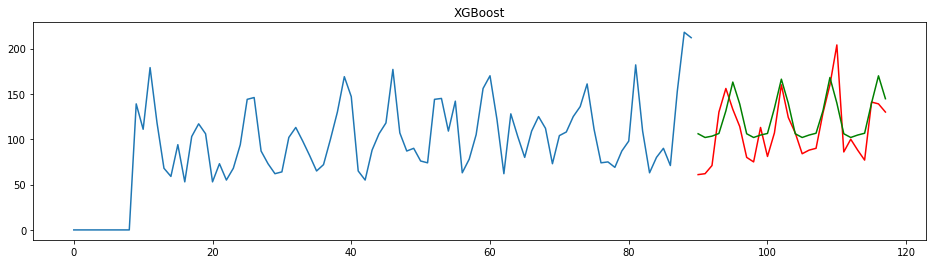

In [272]:
#XG Boost
starting=90

plt.figure(figsize=(16,4))
plt.plot(np.arange(starting),y_train[-starting:] )
plt.plot(range(starting,starting+len(y_test)),y_test,color='red')
plt.plot(range(starting,starting+len(y_test)),prediction_xg_reg,color='green')
plt.title("XGBoost")

plt.show()

# Score

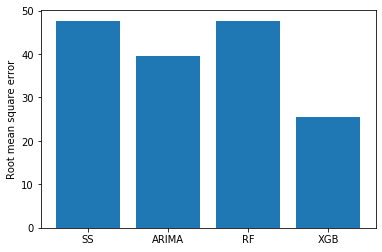

In [276]:
plt.bar(['SS','ARIMA','RF','XGB'],[score_ss,score_arm,score_rf,score_xg_reg])
plt.ylabel('Root mean square error')
plt.show()